- Diego Casta - 35705
- Mauricio Alcántar - 35860
- David Santana - 35967

## **To-Do List**
- Leer Archivo .csv
- Base de Datos
- Agarrar el resultado, ponerlo en la BdD y catalogarlo como canción para hacer la búsqueda
- Contrastar grabación con records (regresión lineal)

## **Librerías**

In [1]:
import numpy as np
from io import BytesIO
from base64 import b64decode
try:
    from google.colab import output
except ImportError:
    pass
from IPython.display import Javascript
import IPython.display as ipd
import io
import soundfile as sf
from scipy import signal as sig
from scipy.io import wavfile as wav

In [2]:
IN_COLAB = None
if 'google.colab' in str(get_ipython()):
  IN_COLAB = True
  print('Ejecutándose en Colab')
else:
  IN_COLAB = False
  print('Ejecutándose localmente')

Ejecutándose localmente


In [3]:
if IN_COLAB:
  !pip install autotime

In [4]:
%load_ext autotime

time: 0 ns (started: 2024-11-20 04:18:46 -08:00)


## **Lectura de archivo**

In [5]:
RECORD = None if not IN_COLAB else """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time));

const b2text = blob => new Promise(resolve => {
  const reader = new FileReader();
  reader.onloadend = e => resolve(e.srcElement.result);
  reader.readAsDataURL(blob);
});

var record = time => new Promise(async resolve => {
  const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
  const audioContext = new AudioContext({ sampleRate: 44100 });
  const source = audioContext.createMediaStreamSource(stream);
  const recorder = new MediaRecorder(stream);
  let chunks = [];

  recorder.ondataavailable = e => chunks.push(e.data);
  alert("Presiona 'aceptar' para empezar la grabación.");
  recorder.start();
  await sleep(time);

  recorder.onstop = async () => {
    const blob = new Blob(chunks, { type: 'audio/ogg; codecs=opus' });
    const arrayBuffer = await blob.arrayBuffer();
    const audioBuffer = await audioContext.decodeAudioData(arrayBuffer);

    // Convert to WAV format
    const wavBlob = encodeWAV(audioBuffer, 44100, 16);
    const wavText = await b2text(wavBlob);
    resolve(wavText);

    // Clean up
    stream.getTracks().forEach(track => track.stop());
    audioContext.close();
  };

  recorder.stop();
});

// WAV encoding function
function encodeWAV(audioBuffer, sampleRate, bitDepth) {
  const numChannels = audioBuffer.numberOfChannels;
  const length = audioBuffer.length * numChannels * (bitDepth / 8);
  const buffer = new ArrayBuffer(44 + length);
  const view = new DataView(buffer);

  // WAV header
  writeString(view, 0, 'RIFF');
  view.setUint32(4, 36 + length, true);
  writeString(view, 8, 'WAVE');
  writeString(view, 12, 'fmt ');
  view.setUint32(16, 16, true);  // Format chunk length
  view.setUint16(20, 1, true);   // PCM format
  view.setUint16(22, numChannels, true);
  view.setUint32(24, sampleRate, true);
  view.setUint32(28, sampleRate * numChannels * (bitDepth / 8), true); // Byte rate
  view.setUint16(32, numChannels * (bitDepth / 8), true); // Block align
  view.setUint16(34, bitDepth, true); // Bits per sample
  writeString(view, 36, 'data');
  view.setUint32(40, length, true);

  // Write PCM samples
  let offset = 44;
  for (let channel = 0; channel < numChannels; channel++) {
    const data = audioBuffer.getChannelData(channel);
    for (let i = 0; i < data.length; i++, offset += 2) {
      const sample = Math.max(-1, Math.min(1, data[i]));
      view.setInt16(offset, sample < 0 ? sample * 0x8000 : sample * 0x7FFF, true);
    }
  }

  return new Blob([view], { type: 'audio/wav' });
}

function writeString(view, offset, string) {
  for (let i = 0; i < string.length; i++) {
    view.setUint8(offset + i, string.charCodeAt(i));
  }
}
"""

def record(sec=10):
  output.eval_js(RECORD)
  sec += 1
  s = output.eval_js('record(%d)' % (sec*1000))
  print("Grabación terminada")
  b = b64decode(s.split(',')[1])
  return b #byte stream

time: 0 ns (started: 2024-11-20 04:18:46 -08:00)


In [6]:
audio = input() if not IN_COLAB else record(10)

 himno


time: 1.95 s (started: 2024-11-20 04:18:46 -08:00)


In [7]:
ipd.display(ipd.Audio(audio if IN_COLAB else './samples/' + audio + '.wav'))

time: 63 ms (started: 2024-11-20 04:18:48 -08:00)


In [8]:
data, sr = None, None
if (IN_COLAB): data, sr = sf.read(io.BytesIO(audio))
else: sr, data = wav.read('./samples/' + audio + '.wav')
if (data.ndim == 2): data = data.mean(axis=1).astype(data.dtype)
print("Sample rate is {0}Hz".format(sr))

Sample rate is 44100Hz
time: 0 ns (started: 2024-11-20 04:18:48 -08:00)


In [9]:
if (IN_COLAB):
  %run /content/MAAS_Filters.ipynb
else:
  %run ./MAAS_Filters.ipynb

time: 469 ms (started: 2024-11-20 04:18:48 -08:00)


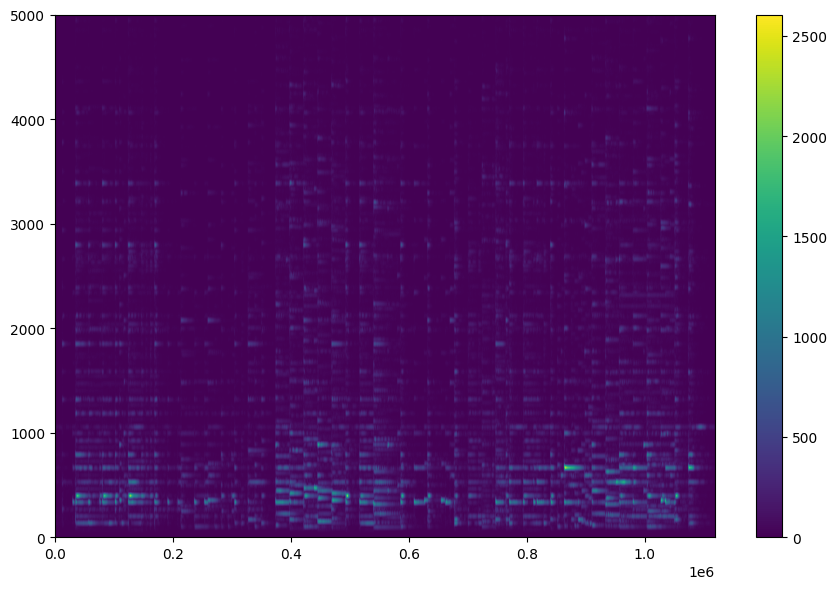

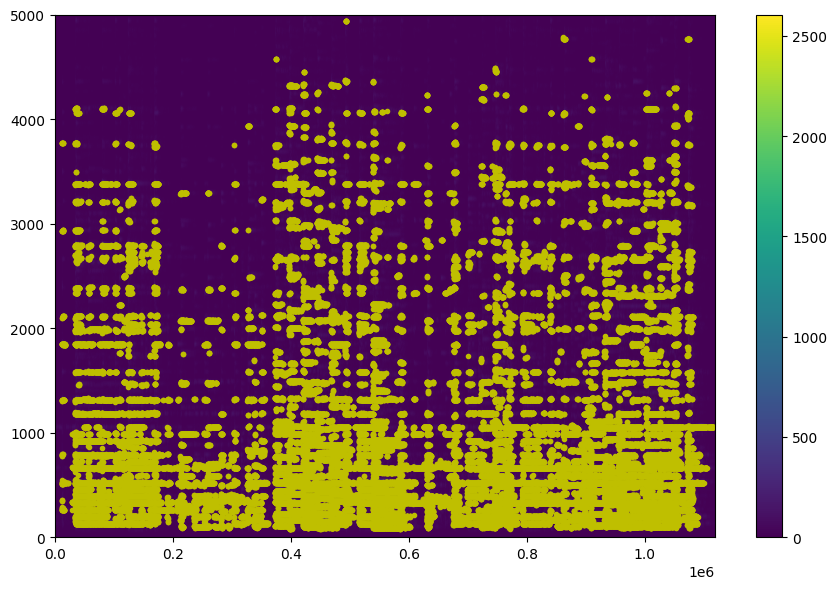

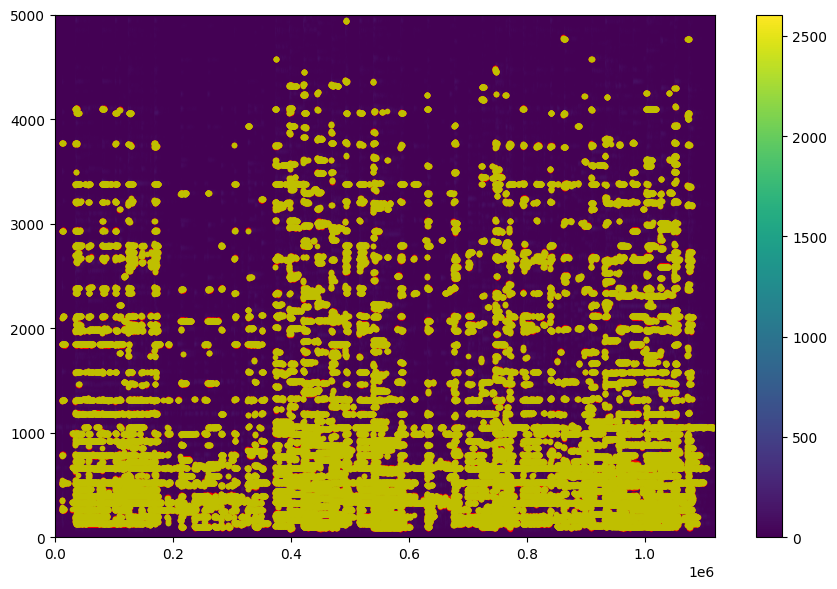

In [ ]:
filtered = MAAS_filter(data, sr, None if IN_COLAB else './database/' + audio + '.csv')

In [ ]:
filtered